In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import pandas as pd 
import random
import plotnine
from plotnine import * 
np.random.seed(1234)
random.seed(1234)


In [2]:
#load the data 
entries=pickle.load(open('cnn_inputs.p','rb'))
X=entries['X']
y=entries['y']

In [4]:
neil1_indices=[i for i in indices if i.startswith('NEIL')]
ttyh2_indices=[i for i in indices if i.start]

['NEIL1_57',
 'TTYH2_BC_116',
 'TTYH2_BC_51',
 'AJUBA_32',
 'TTYH2_ECS_142',
 'AJUBA_54',
 'NEIL1_229',
 'AJUBA_192',
 'AJUBA_80',
 'NEIL1_130',
 'TTYH2_BC_100',
 'TTYH2_BC_25',
 'TTYH2_ECS_56',
 'AJUBA_36',
 'NEIL1_125',
 'TTYH2_BC_26',
 'AJUBA_21',
 'TTYH2_BC_22',
 'NEIL1_219',
 'NEIL1_154',
 'TTYH2_BC_162',
 'NEIL1_233',
 'TTYH2_ECS_60',
 'TTYH2_ECS_124',
 'NEIL1_215',
 'AJUBA_214',
 'NEIL1_38',
 'TTYH2_ECS_100',
 'TTYH2_ECS_147',
 'AJUBA_120',
 'NEIL1_61',
 'TTYH2_BC_5',
 'NEIL1_142',
 'AJUBA_244',
 'AJUBA_239',
 'TTYH2_BC_181',
 'TTYH2_ECS_92',
 'TTYH2_BC_160',
 'NEIL1_180',
 'NEIL1_27',
 'TTYH2_ECS_44',
 'TTYH2_BC_106',
 'TTYH2_ECS_78',
 'TTYH2_BC_164',
 'NEIL1_110',
 'NEIL1_292',
 'NEIL1_265',
 'NEIL1_121',
 'TTYH2_BC_44',
 'NEIL1_22',
 'NEIL1_139',
 'TTYH2_ECS_55',
 'TTYH2_BC_58',
 'TTYH2_ECS_88',
 'AJUBA_160',
 'AJUBA_92',
 'NEIL1_7',
 'TTYH2_BC_91',
 'NEIL1_177',
 'TTYH2_ECS_63',
 'TTYH2_ECS_168',
 'TTYH2_BC_9',
 'TTYH2_BC_70',
 'TTYH2_BC_150',
 'AJUBA_229',
 'NEIL1_88',
 'TT

In [3]:
#create train,test,validate splits 
indices=list(X.keys())
print(len(indices))
print(len(y.keys()))
print(indices[0:10])
random.shuffle(indices)
num_items=len(indices)
#split 70% train, 15% validate, 15% test 
num_train=int(round(0.7*num_items))
num_validate=int(round(0.15*num_items))
num_test=num_items-num_train-num_validate 

924
924
['NEIL1_1', 'NEIL1_2', 'NEIL1_3', 'NEIL1_4', 'NEIL1_5', 'NEIL1_6', 'NEIL1_7', 'NEIL1_8', 'NEIL1_9', 'NEIL1_10']


In [4]:
print(num_train)
print(num_validate)
print(num_test)

647
139
138


In [5]:
train_indices=indices[0:num_train]
validate_indices=indices[num_train:num_train+num_validate]
test_indices=indices[num_train+num_validate::]


In [6]:
train_X_seq=np.array([X[i][0] for i in train_indices])
train_X_struct=np.array([X[i][1] for i in train_indices])
train_X=[train_X_seq,train_X_struct]

validate_X_seq=np.array([X[i][0] for i in validate_indices])
validate_X_struct=np.array([X[i][1] for i in validate_indices])
validate_X=[validate_X_seq,validate_X_struct]

test_X_seq=np.array([X[i][0] for i in test_indices])
test_X_struct=np.array([X[i][1] for i in test_indices])
test_X=[test_X_seq,test_X_struct]

In [7]:
train_y=np.asarray([y[i] for i in train_indices])
validate_y=np.asarray([y[i] for i in validate_indices])
test_y=np.asarray([y[i] for i in test_indices])

In [8]:
train_X_seq.shape

(647, 166, 4)

In [9]:
train_X_struct.shape

(647, 166, 6)

In [10]:
train_y.shape

(647,)

## Create keras model 

In [35]:
#import keras dependencies 
import keras
from keras.models import Model
from keras.layers import Input, Concatenate
from keras.layers.core import  Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras import backend as K
from kerasAC.custom_losses import * 

In [36]:
#define a keras model 
K.set_image_data_format('channels_last')
padding='same'
seq_input=Input(shape=(166,4),name='seq_input')
struct_input=Input(shape=(166,6),name='struct_input')
x_seq=Conv1D(filters=1,kernel_size=6,input_shape=(166,4),padding=padding,name='conv_seq')(seq_input)
x_struct=Conv1D(filters=1,kernel_size=6,input_shape=(166,6),padding=padding,name='conv_struct')(struct_input)
x_seq=Activation('relu',name='activation_1')(x_seq)
x_struct=Activation('relu',name='activation_2')(x_struct)
x_seq=Flatten(name='flatten1')(x_seq)
x_struct=Flatten(name='flatten2')(x_struct)
aggregated=Concatenate(axis=-1)([x_struct,x_seq])
x=Dense(32,name='dense1')(aggregated)
x=Activation('relu',name='activation_3')(x)
outputs=Dense(1,name='final')(x)
model=Model(inputs=[seq_input,struct_input],outputs=outputs)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam,loss=ambig_mean_squared_error)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
struct_input (InputLayer)       (None, 166, 6)       0                                            
__________________________________________________________________________________________________
seq_input (InputLayer)          (None, 166, 4)       0                                            
__________________________________________________________________________________________________
conv_struct (Conv1D)            (None, 166, 1)       37          struct_input[0][0]               
__________________________________________________________________________________________________
conv_seq (Conv1D)               (None, 166, 1)       25          seq_input[0][0]                  
____________________________________________________________________________________________

## Train the model 

In [38]:
from keras.callbacks import * 
from kerasAC.custom_callbacks import * 


In [39]:
#define callbacks 
checkpointer = ModelCheckpoint(filepath="model.hdf5", verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)
history=LossHistory("logs.batch",['loss','val_loss'])
csvlogger = CSVLogger("logs.epoch.csv", append = False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4,patience=2, min_lr=0.00000001)
cur_callbacks=[checkpointer,earlystopper,csvlogger,reduce_lr,history]


In [40]:
#fit the model 
model.fit(x=train_X,
          y=train_y,
          batch_size=32,
          epochs=40,
          verbose=1,
          callbacks=cur_callbacks,
          validation_data=(validate_X,validate_y),
          shuffle=True,
          max_queue_size=100,
          use_multiprocessing=True,
          workers=12)


Train on 647 samples, validate on 139 samples
Epoch 1/40
647/647 [==============================] - 1s 1ms/step - loss: 0.0409 - val_loss: 0.0357

Epoch 00001: val_loss improved from inf to 0.03575, saving model to model.hdf5


NotImplementedError: numpy() is only available when eager execution is enabled.

## plot the loss curves 

In [ ]:
## plot the losses
losses=pd.read_csv("logs.epoch.csv",header=0,sep=',')
losses.shape
batch_losses=pd.read_csv("logs.batch",header=0,sep='\t')
losses=pd.melt(losses,id_vars='epoch')
losses['variable'][losses['variable']=='loss']='TrainingLoss'
losses['variable'][losses['variable']=='val_loss']='ValidationLoss'
plotnine.options.figure_size = (6, 6)
(ggplot(losses,aes(x='epoch',
                   y='value',
                   group='variable',
                   color='variable'))+geom_line(size=2)+theme_bw(20))


In [ ]:
batch_losses['sequence']=batch_losses.index
plotnine.options.figure_size = (6, 6)


(ggplot(batch_losses,aes(x="sequence",y="loss"))+geom_line()+ylab("Training Loss MSE"))

## get predictions

In [ ]:
predictions_test=model.predict(test_X,batch_size=128,max_queue_size=100,use_multiprocessing=True,workers=4)

In [ ]:
predictions_train=model.predict(train_X,batch_size=128,max_queue_size=100,use_multiprocessing=True,workers=4)

In [41]:
predictions_validate=model.predict(validate_X,batch_size=128,max_queue_size=100,use_multiprocessing=True,workers=4)

In [42]:
#get performance metrics 
from kerasAC.performance_metrics.regression_performance_metrics import *
test_perf=get_performance_metrics_regression(predictions_test,np.expand_dims(test_y,axis=1))
test_perf

predictions shape:(138, 1)
true labels shape:(138, 1)


{'spearmanr': [SpearmanrResult(correlation=0.7320185566373393, pvalue=2.0395195328895518e-23)],
 'pearsonr': [(0.7799227246631438, 3.1149445886678866e-28)],
 'spearmanr_nonzerobins': [SpearmanrResult(correlation=0.7375893541937842, pvalue=9.465581194391311e-24)],
 'pearsonr_nonzerobins': [(0.7798828231677826, 5.047643887468204e-28)]}

In [43]:
train_perf=get_performance_metrics_regression(predictions_train,np.expand_dims(train_y,axis=1))
train_perf

predictions shape:(647, 1)
true labels shape:(647, 1)


{'spearmanr': [SpearmanrResult(correlation=0.8034571823754847, pvalue=5.118084775009291e-144)],
 'pearsonr': [(0.8732539835346266, 7.128579152468945e-199)],
 'spearmanr_nonzerobins': [SpearmanrResult(correlation=0.8062280017672417, pvalue=3.7454016738359503e-144)],
 'pearsonr_nonzerobins': [(0.8732106176885885, 1.2140451803905308e-196)]}

In [44]:
valid_perf=get_performance_metrics_regression(predictions_validate,np.expand_dims(validate_y,axis=1))
valid_perf

predictions shape:(139, 1)
true labels shape:(139, 1)


{'spearmanr': [SpearmanrResult(correlation=0.3954385339782177, pvalue=2.2579214493065893e-06)],
 'pearsonr': [(0.39936707035090635, 1.7517551444802938e-06)],
 'spearmanr_nonzerobins': [SpearmanrResult(correlation=0.41931595625842083, pvalue=5.60483113555239e-07)],
 'pearsonr_nonzerobins': [(0.4077548576197013, 1.2173227997539127e-06)]}

In [45]:
#plot the predictions 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, title, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    nan_indices=[i[0] for i in np.argwhere(np.isnan(x))]
    y= np.delete(y, nan_indices, 0)
    x=np.delete(x,nan_indices,0)

    if ax is None :
        fig , ax = plt.subplots(figsize=(4, 3), dpi= 80, facecolor='w', edgecolor='k')
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs,s=1 )
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    plt.title(title)
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

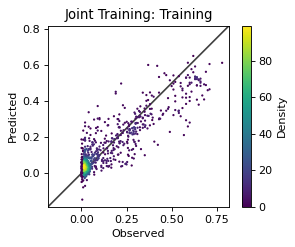

In [46]:
density_scatter(train_y,np.squeeze(predictions_train),'Joint Training: Training',bins=[30,30])

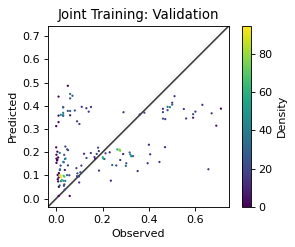

In [47]:
density_scatter(validate_y,np.squeeze(predictions_validate),'Joint Training: Validation',bins=[30,30])

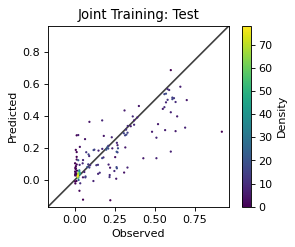

In [48]:
density_scatter(test_y,np.squeeze(predictions_test),'Joint Training: Test',bins=[30,30])

In [49]:
import tensorflow as tf 
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()


In [50]:
# select a set of background examples to take an expectation over
background=train_X

In [51]:

import shap

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)


In [57]:
shap_vals=e.shap_values(test_X)[0]

In [61]:
shap_vals[0][0].shape

(166, 4)